In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


In [2]:
def show_tensor_image(tensor):  # 텐서 순서를 (C, H, W)에서 (H, W, C)로 변경하고 numpy array로 변환
    image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
def val_plot(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Test Loss')

    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')  # , color='orange'
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

In [4]:
def cuda_message():
    if torch.cuda.is_available():
        print("CUDA(GPU)를 사용합니다.")
    else:
        print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda_message()

CUDA(GPU)를 사용합니다.


In [6]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, model_num=18, num_classes=2):
        super(myResNet, self).__init__()

        if model_num == 18:
            self.resnet = models.resnet18(weights=None)
        elif model_num == 34:
            self.resnet = models.resnet34(weights=None)
        elif model_num == 50:
            self.resnet = models.resnet50(weights=None)
        elif model_num == 101:
            self.resnet = models.resnet101(weights=None)
        elif model_num == 152:
            self.resnet = models.resnet152(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
# myVGG 클래스 정의
class myVGG(nn.Module):
    def __init__(self, model_kind="16", num_classes=2):
        super(myVGG, self).__init__()

        if model_kind == "11":
            self.vgg = models.vgg11(weights=None)
        elif model_kind == "11_bn":
            self.vgg = models.vgg11_bn(weights=None)
        elif model_kind == "13":
            self.vgg = models.vgg13(weights=None)
        elif model_kind == "13_bn":
            self.vgg = models.vgg13_bn(weights=None)
        elif model_kind == "16":
            self.vgg = models.vgg16(weights=None)
        elif model_kind == "16_bn":
            self.vgg = models.vgg16_bn(weights=None)
        elif model_kind == "19":
            self.vgg = models.vgg19(weights=None)
        elif model_kind == "19_bn":
            self.vgg = models.vgg19_bn(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vgg.classifier[6].in_features  # classifier["6"] -> 6, vgg에서 정해진 수?
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [8]:
# myLeNet 클래스 정의
class myLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(myLeNet, self).__init__()
        self.lenet = models.googlenet(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.lenet.fc.in_features
        self.lenet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.lenet(x)

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()  # 어차피 train에선 test와 달리 loss.backward() 해야하기 때문에 loss 따로 객체화
        loss.backward()
        optimizer.step()
    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)  # output.argmax(dim=1, keepdim=True)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()  # pred.eq(target.view_as(pred)).sum().item()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # .view_as(): View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size())
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()
    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [12]:
# import shutil
# shutil.rmtree('C:/Users/bgmbg/Downloads/face_age/.ipynb_checkpoints')

In [13]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

# 아래 수정/출력 요망

# full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
# test_dataset_origin = ImageFolder('IMAGE/Covid19-dataset/test', transform=trans_origin)
# test_loader_origin = torch.utils.data.DataLoader(test_dataset_origin, batch_size=64, shuffle=False)

# original_images, _ = next(iter(test_loader_origin))
# transform_images, _ = next(iter(test_loader))

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(4, 6)

# for idx in range(3):
#     axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 0].set_axis_off()
#     axes[idx, 0].set_title('Original (200,200)')
#     axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 1].set_axis_off()
#     axes[idx, 1].set_title('Resized (100,100)')
#     axes[idx, 2].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 2].set_axis_off()
#     axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
# plt.show()

In [14]:
# # 데이터 증강! (500sets 이하 애들만 2배 뻥튀기)

# # 입력 이미지 디렉토리
# input_dir = "C:/Users/USER/Desktop/FaceAge_project/face_age"

# # 출력 이미지 디렉토리
# output_dir = "C:/Users/USER/Desktop/FaceAge_project/face_age"
# os.makedirs(output_dir, exist_ok=True)

# aug_needed = ["/10-12", "/13-15", "/30-34", "/40-44", "/45-49", "/55-59", "/60-64", "/65-69"]

# # 각 디렉토리를 돌면서 이미지 증강 및 저장
# for category_dir in aug_needed:
#     category_path = input_dir + '' + category_dir
#     print(input_dir)
#     print(category_path)
#     if os.path.isdir(category_path):
#         category_output_dir = output_dir + '' + category_dir
#         print(category_output_dir)
#         os.makedirs(category_output_dir, exist_ok=True)
        
#         # 이미지를 순회하면서 증강 및 저장
#         for filename in os.listdir(category_path):
#             print(filename)
#             if filename.endswith(".jpg") or filename.endswith(".png"):
#                 img_path = category_path + '/' + filename
#                 print(img_path)
#                 # 이미지 불러오기
#                 img_plus = cv2.imread(img_path)
#                 img_plus = cv2.cvtColor(img_plus, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽어옴.  # , cv2.COLOR_BGR2RGB
                
#                 # 이미지 증강
#                 img_flip_lr = cv2.flip(img_plus,1)
                
#                 # 증강된 이미지 저장
#                 cv2.imwrite(category_output_dir + '/' + f"{filename}_flip_lr.jpg", cv2.cvtColor(img_flip_lr, cv2.COLOR_RGB2BGR))

In [15]:
torch.manual_seed(42)

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    # transforms.Resize((100, 100)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874),
                         (0.21104145, 0.18984404, 0.18253866))  # 이미지를 -1에서 1로 정규화
])
# 데이터셋 로드
full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
print(full_dataset)
count = Counter(full_dataset.targets)
print(count)

# 데이터를 훈련셋과 테스트셋으로 랜덤으로 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

cnt = []
for i in range(train_size):  # 
    cnt.append(train_dataset[i][1])
print(Counter(cnt))
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 12652
    Root location: ./face_age
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.6360717, 0.4874842, 0.41885874), std=(0.21104145, 0.18984404, 0.18253866))
           )
Counter({0: 1112, 7: 960, 6: 856, 13: 798, 17: 794, 4: 759, 11: 742, 2: 710, 14: 678, 5: 661, 15: 634, 1: 618, 10: 608, 3: 554, 8: 554, 9: 554, 12: 539, 16: 521})
Counter({0: 886, 7: 750, 6: 676, 13: 651, 17: 629, 4: 618, 11: 585, 2: 573, 14: 563, 5: 534, 15: 508, 1: 480, 10: 472, 9: 460, 3: 456, 8: 437, 16: 428, 12: 415})


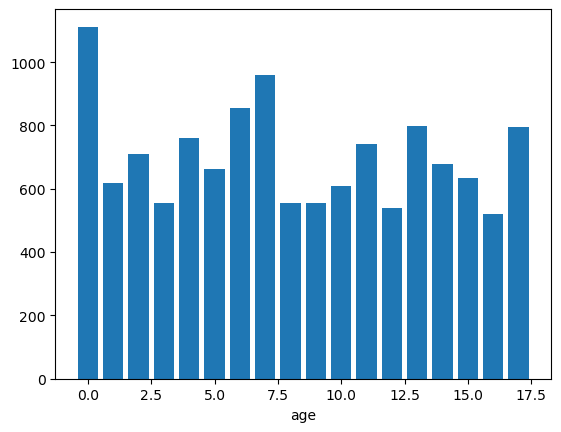

In [16]:
# 인덱스, 눈금 수정 요망
# age_sorted = ['1', '2-3', '4-6', '7-9', '10-12',
#               '13-15', '16-19', '20-24', '25-29', '30-34',
#               '35-39', '40-44', '45-49', '50-54', '55-59',
#               '60-64', '65-69', '70']
# age_dict = {'1': 0, '10-12': 1, '13-15': 2, '16-19': 3, '2-3': 4,
#             '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, '4-6': 9,
#             '40-44': 10, '45-49': 11, '50-54': 12, '55-59': 13, '60-64': 14,
#             '65-69': 15, '7-9': 16, '70': 17}

age_list = list(count.keys())
frequencies = list(count.values())

plt.bar(age_list, frequencies)
plt.xlabel('age')
plt.show()

In [17]:
### 1. resnet18
### 1-1. resnet18 / SGD
### 1-2. resnet18 / RMSprop
### 1-3. resnet18 / AdamW
### 2. vgg13
### 3. googlenet

### 1-1-1. resnet18 / SGD(lr=0.010, mo=0.9)

In [18]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [19]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [20]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4504, Accuracy: 11.11%
Test loss: 2.2845, Accuracy: 22.36%
Epoch 2, Training loss: 2.0614, Accuracy: 11.11%
Test loss: 2.2624, Accuracy: 21.81%
Epoch 3, Training loss: 1.8031, Accuracy: 22.22%
Test loss: 2.0627, Accuracy: 29.63%
Epoch 4, Training loss: 1.6118, Accuracy: 22.22%
Test loss: 2.3219, Accuracy: 28.41%
Epoch 5, Training loss: 1.3882, Accuracy: 55.56%
Test loss: 2.1093, Accuracy: 29.20%
Epoch 6, Training loss: 1.2404, Accuracy: 22.22%
Test loss: 2.0576, Accuracy: 33.15%
Epoch 7, Training loss: 1.0319, Accuracy: 55.56%
Test loss: 2.1826, Accuracy: 33.15%
Epoch 8, Training loss: 0.8345, Accuracy: 55.56%
Test loss: 2.4097, Accuracy: 33.74%
Epoch 9, Training loss: 0.6618, Accuracy: 55.56%
Test loss: 2.6706, Accuracy: 33.50%
Epoch 10, Training loss: 0.5968, Accuracy: 88.89%
Test loss: 2.8983, Accuracy: 30.58%
Epoch 11, Training loss: 0.3688, Accuracy: 88.89%
Test loss: 2.9401, Accuracy: 34.02%
Epoch 12, Training loss: 0.3250, Accuracy: 88.89%
Test loss: 3.

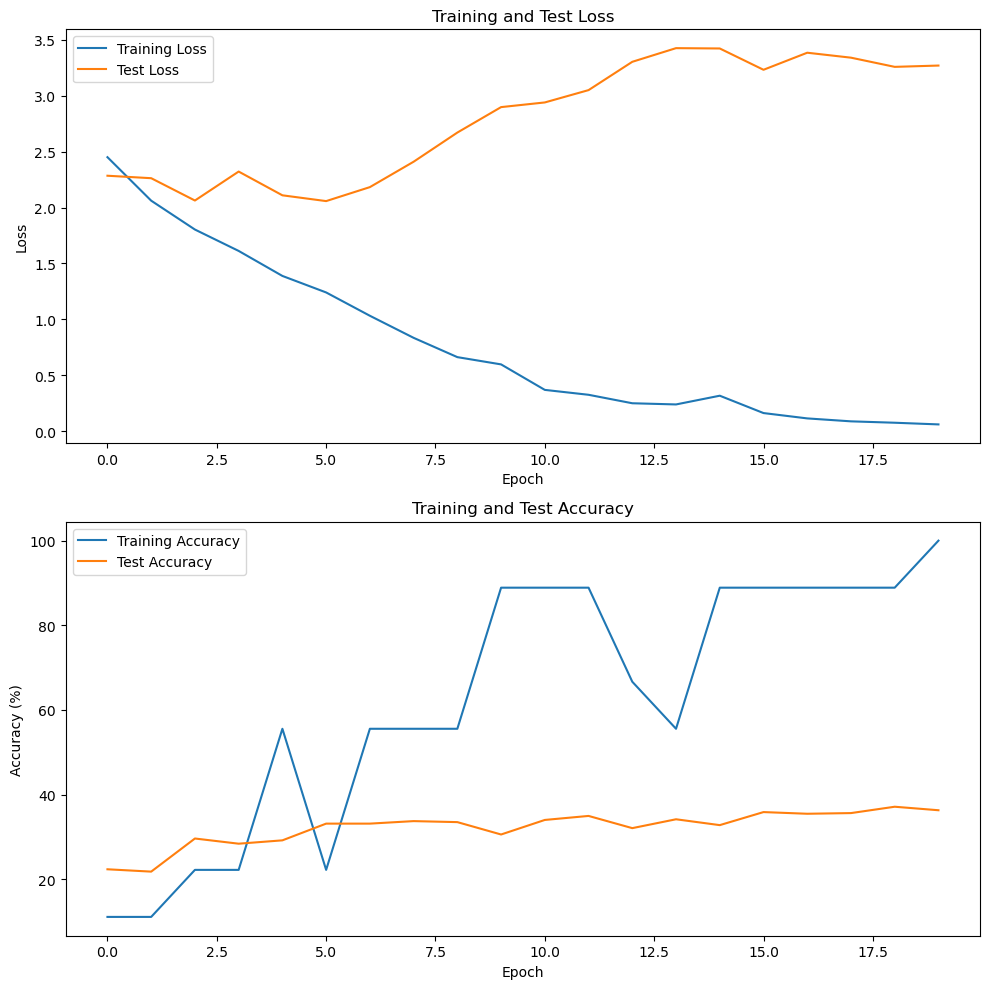

In [21]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-2. resnet18 / SGD(lr=0.010, mo=0.5)

In [22]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.5)

In [23]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [24]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5603, Accuracy: 0.00%
Test loss: 2.4252, Accuracy: 16.04%
Epoch 2, Training loss: 2.1312, Accuracy: 0.00%
Test loss: 2.3375, Accuracy: 17.90%
Epoch 3, Training loss: 1.8826, Accuracy: 55.56%
Test loss: 2.1004, Accuracy: 26.04%
Epoch 4, Training loss: 1.6403, Accuracy: 11.11%
Test loss: 2.0182, Accuracy: 26.83%
Epoch 5, Training loss: 1.3918, Accuracy: 55.56%
Test loss: 2.1708, Accuracy: 25.21%
Epoch 6, Training loss: 1.1124, Accuracy: 55.56%
Test loss: 2.0663, Accuracy: 30.78%
Epoch 7, Training loss: 0.8344, Accuracy: 77.78%
Test loss: 2.3471, Accuracy: 28.96%
Epoch 8, Training loss: 0.5585, Accuracy: 55.56%
Test loss: 2.4007, Accuracy: 31.92%
Epoch 9, Training loss: 0.3766, Accuracy: 44.44%
Test loss: 3.3783, Accuracy: 26.55%
Epoch 10, Training loss: 0.3243, Accuracy: 100.00%
Test loss: 2.5928, Accuracy: 32.60%
Epoch 11, Training loss: 0.1615, Accuracy: 100.00%
Test loss: 2.6930, Accuracy: 30.94%
Epoch 12, Training loss: 0.1175, Accuracy: 77.78%
Test loss: 3.

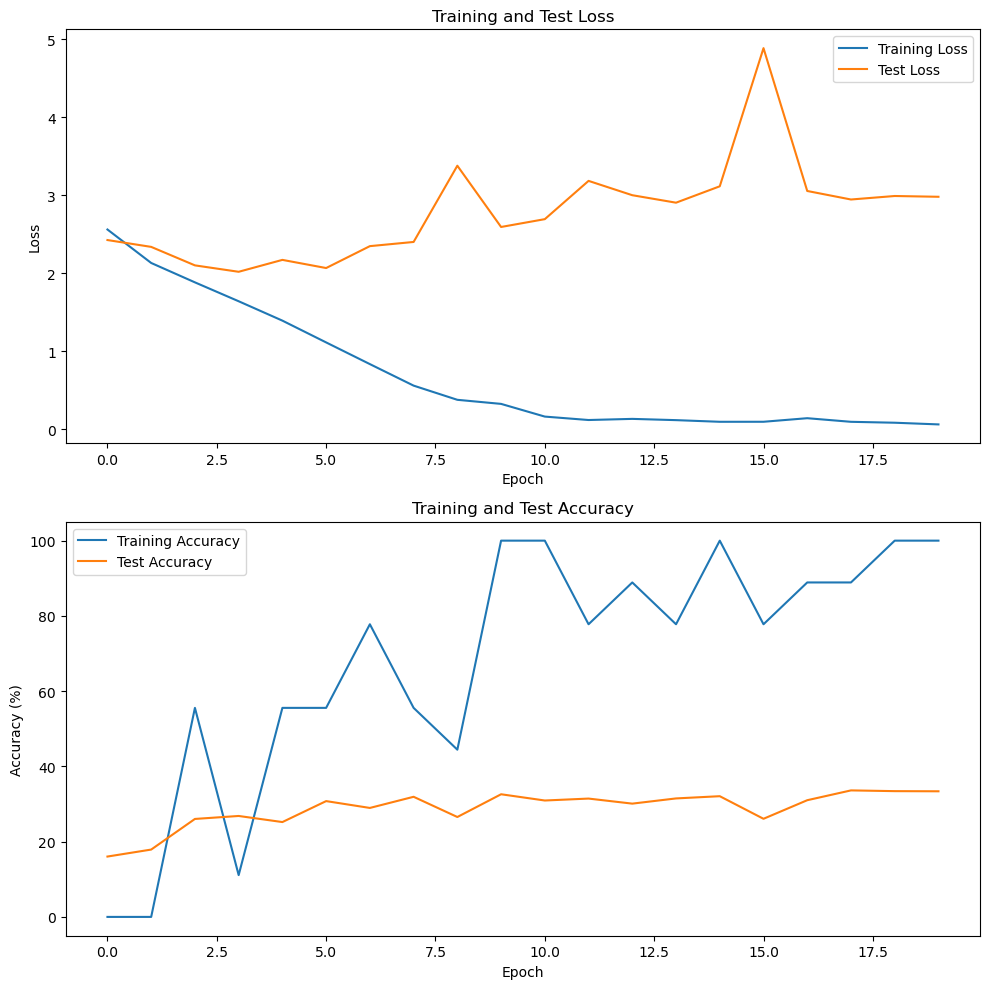

In [25]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-3. resnet18 / SGD(lr=0.010, mo=0.25)

In [26]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.25)

In [27]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [28]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6330, Accuracy: 33.33%
Test loss: 2.5592, Accuracy: 17.11%
Epoch 2, Training loss: 2.2201, Accuracy: 0.00%
Test loss: 2.3822, Accuracy: 16.55%
Epoch 3, Training loss: 1.9862, Accuracy: 22.22%
Test loss: 2.1699, Accuracy: 24.54%
Epoch 4, Training loss: 1.7735, Accuracy: 44.44%
Test loss: 2.2003, Accuracy: 23.98%
Epoch 5, Training loss: 1.5598, Accuracy: 55.56%
Test loss: 2.0702, Accuracy: 26.43%
Epoch 6, Training loss: 1.3220, Accuracy: 33.33%
Test loss: 2.0782, Accuracy: 27.78%
Epoch 7, Training loss: 1.0698, Accuracy: 44.44%
Test loss: 2.3267, Accuracy: 26.20%
Epoch 8, Training loss: 0.8180, Accuracy: 77.78%
Test loss: 2.3715, Accuracy: 26.87%
Epoch 9, Training loss: 0.5514, Accuracy: 100.00%
Test loss: 2.3962, Accuracy: 28.61%
Epoch 10, Training loss: 0.3197, Accuracy: 66.67%
Test loss: 2.7893, Accuracy: 26.16%
Epoch 11, Training loss: 0.2200, Accuracy: 77.78%
Test loss: 3.1944, Accuracy: 27.26%
Epoch 12, Training loss: 0.1640, Accuracy: 88.89%
Test loss: 2.

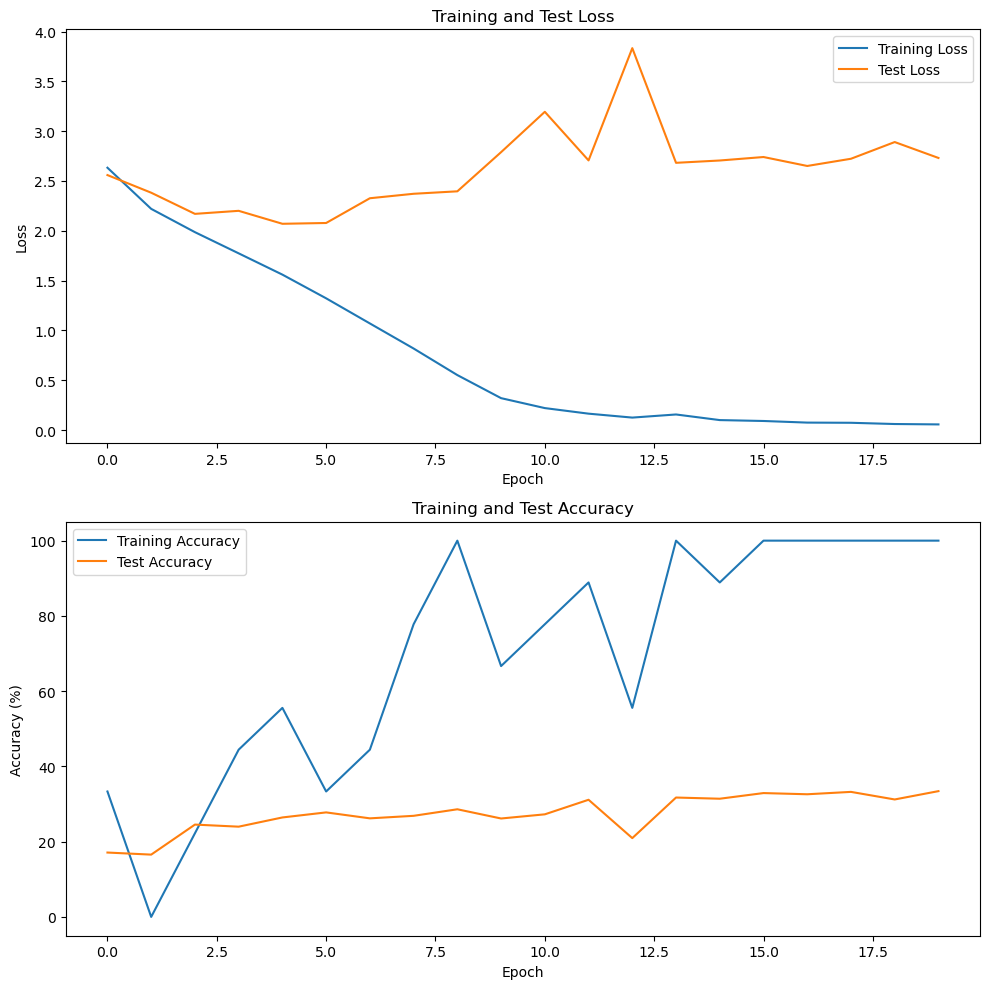

In [29]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-4. resnet18 / SGD(lr=0.005, mo=0.9)

In [30]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [31]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [32]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4954, Accuracy: 11.11%
Test loss: 2.3079, Accuracy: 21.14%
Epoch 2, Training loss: 2.0546, Accuracy: 22.22%
Test loss: 2.1031, Accuracy: 27.30%
Epoch 3, Training loss: 1.8172, Accuracy: 11.11%
Test loss: 2.0765, Accuracy: 27.06%
Epoch 4, Training loss: 1.5887, Accuracy: 55.56%
Test loss: 2.0158, Accuracy: 29.87%
Epoch 5, Training loss: 1.3423, Accuracy: 44.44%
Test loss: 2.0946, Accuracy: 28.61%
Epoch 6, Training loss: 1.1154, Accuracy: 55.56%
Test loss: 2.0218, Accuracy: 33.19%
Epoch 7, Training loss: 0.9157, Accuracy: 33.33%
Test loss: 2.3522, Accuracy: 32.64%
Epoch 8, Training loss: 0.7309, Accuracy: 55.56%
Test loss: 2.4646, Accuracy: 31.85%
Epoch 9, Training loss: 0.5094, Accuracy: 66.67%
Test loss: 2.4894, Accuracy: 33.66%
Epoch 10, Training loss: 0.3939, Accuracy: 77.78%
Test loss: 2.7859, Accuracy: 32.16%
Epoch 11, Training loss: 0.3828, Accuracy: 77.78%
Test loss: 2.8145, Accuracy: 33.74%
Epoch 12, Training loss: 0.2563, Accuracy: 66.67%
Test loss: 3.

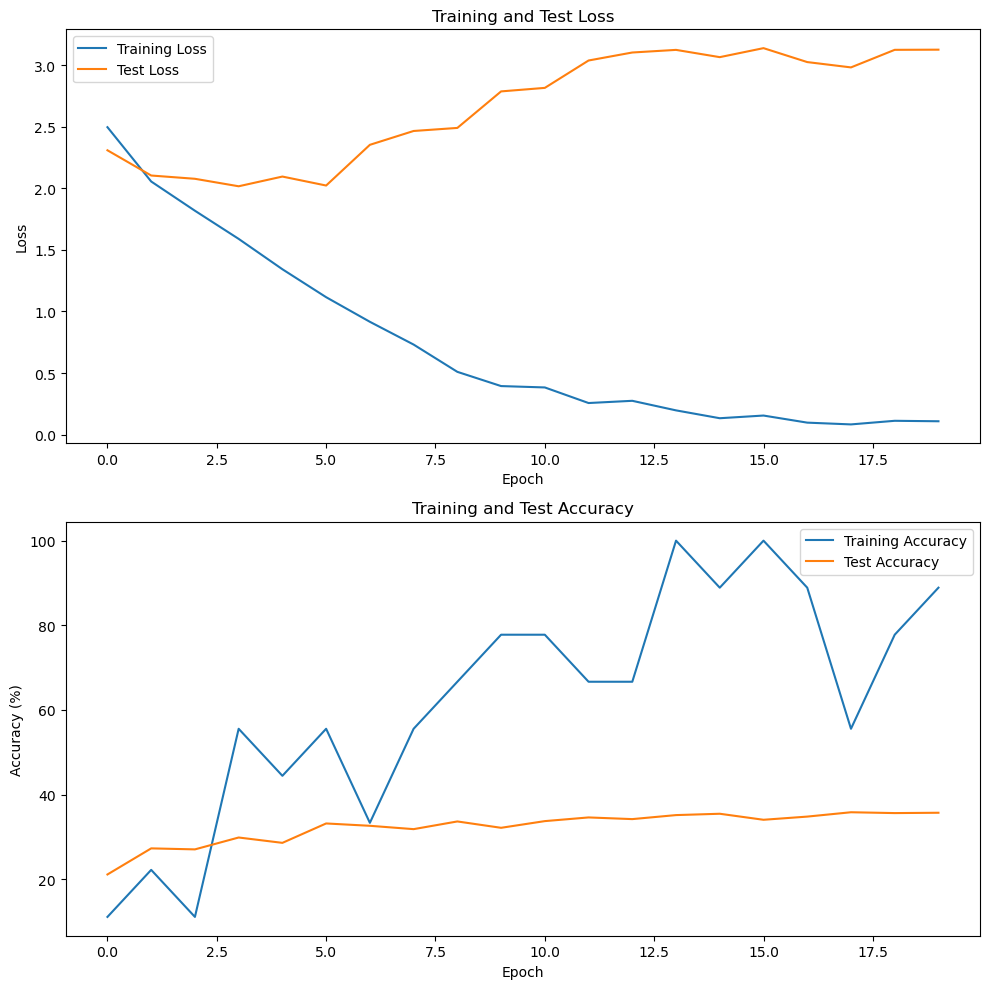

In [33]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-5. resnet18 / SGD(lr=0.005, mo=0.5)

In [34]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

In [35]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [36]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6811, Accuracy: 0.00%
Test loss: 2.5018, Accuracy: 17.50%
Epoch 2, Training loss: 2.2942, Accuracy: 33.33%
Test loss: 2.2548, Accuracy: 23.23%
Epoch 3, Training loss: 2.0529, Accuracy: 33.33%
Test loss: 2.1499, Accuracy: 24.69%
Epoch 4, Training loss: 1.8584, Accuracy: 44.44%
Test loss: 2.0968, Accuracy: 25.52%
Epoch 5, Training loss: 1.6578, Accuracy: 55.56%
Test loss: 2.0322, Accuracy: 27.54%
Epoch 6, Training loss: 1.4549, Accuracy: 44.44%
Test loss: 1.9991, Accuracy: 30.58%
Epoch 7, Training loss: 1.2257, Accuracy: 77.78%
Test loss: 2.0170, Accuracy: 31.53%
Epoch 8, Training loss: 0.9967, Accuracy: 55.56%
Test loss: 2.0261, Accuracy: 30.62%
Epoch 9, Training loss: 0.7524, Accuracy: 55.56%
Test loss: 2.1740, Accuracy: 29.04%
Epoch 10, Training loss: 0.5397, Accuracy: 77.78%
Test loss: 2.3077, Accuracy: 30.70%
Epoch 11, Training loss: 0.3389, Accuracy: 66.67%
Test loss: 2.6387, Accuracy: 26.59%
Epoch 12, Training loss: 0.2561, Accuracy: 100.00%
Test loss: 2.

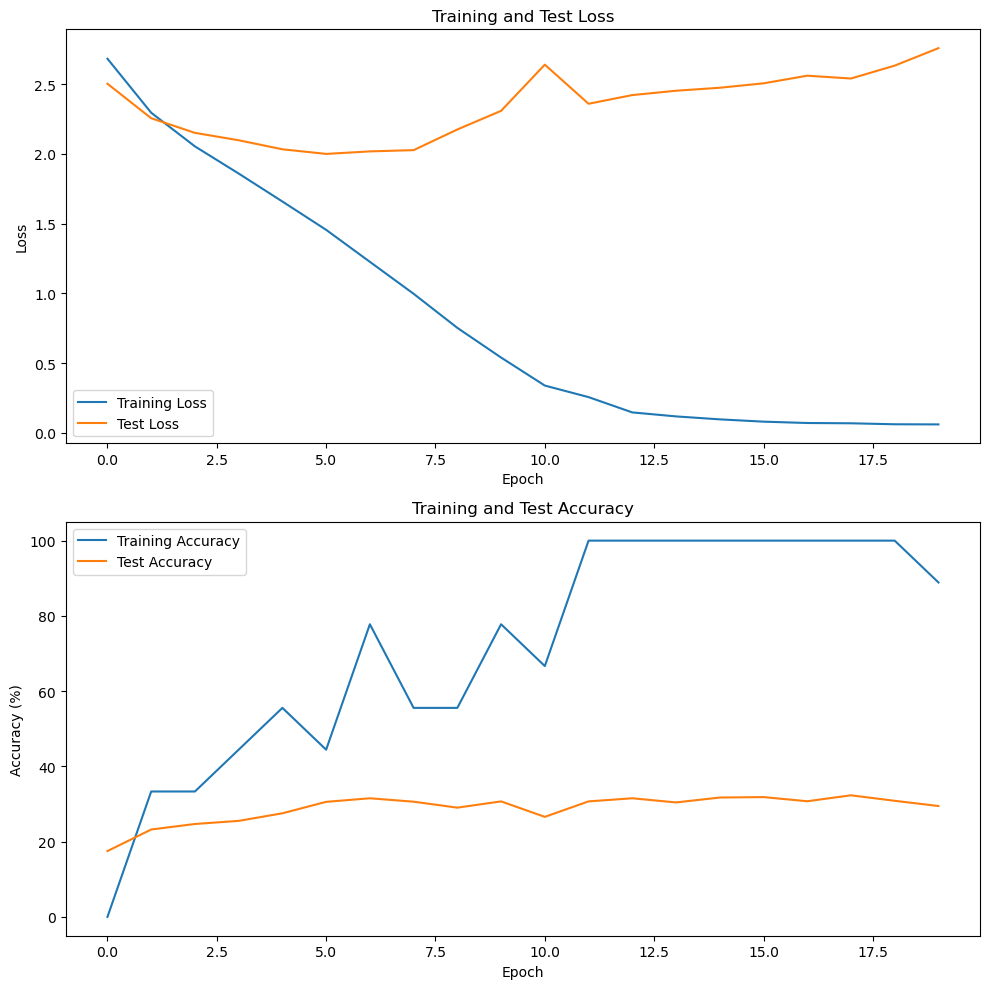

In [37]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-6. resnet18 / SGD(lr=0.005, mo=0.25)

In [38]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.25)

In [39]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [40]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6953, Accuracy: 22.22%
Test loss: 2.5435, Accuracy: 17.62%
Epoch 2, Training loss: 2.3685, Accuracy: 22.22%
Test loss: 2.3398, Accuracy: 22.05%
Epoch 3, Training loss: 2.1607, Accuracy: 22.22%
Test loss: 2.2160, Accuracy: 22.84%
Epoch 4, Training loss: 1.9776, Accuracy: 44.44%
Test loss: 2.1332, Accuracy: 26.12%
Epoch 5, Training loss: 1.8221, Accuracy: 11.11%
Test loss: 2.0224, Accuracy: 28.80%
Epoch 6, Training loss: 1.6641, Accuracy: 33.33%
Test loss: 2.0465, Accuracy: 28.92%
Epoch 7, Training loss: 1.4906, Accuracy: 33.33%
Test loss: 2.0099, Accuracy: 28.49%
Epoch 8, Training loss: 1.3129, Accuracy: 11.11%
Test loss: 2.2506, Accuracy: 26.00%
Epoch 9, Training loss: 1.1292, Accuracy: 33.33%
Test loss: 2.0097, Accuracy: 30.11%
Epoch 10, Training loss: 0.9383, Accuracy: 77.78%
Test loss: 2.0266, Accuracy: 31.69%
Epoch 11, Training loss: 0.7459, Accuracy: 55.56%
Test loss: 2.0435, Accuracy: 31.81%
Epoch 12, Training loss: 0.5796, Accuracy: 44.44%
Test loss: 2.

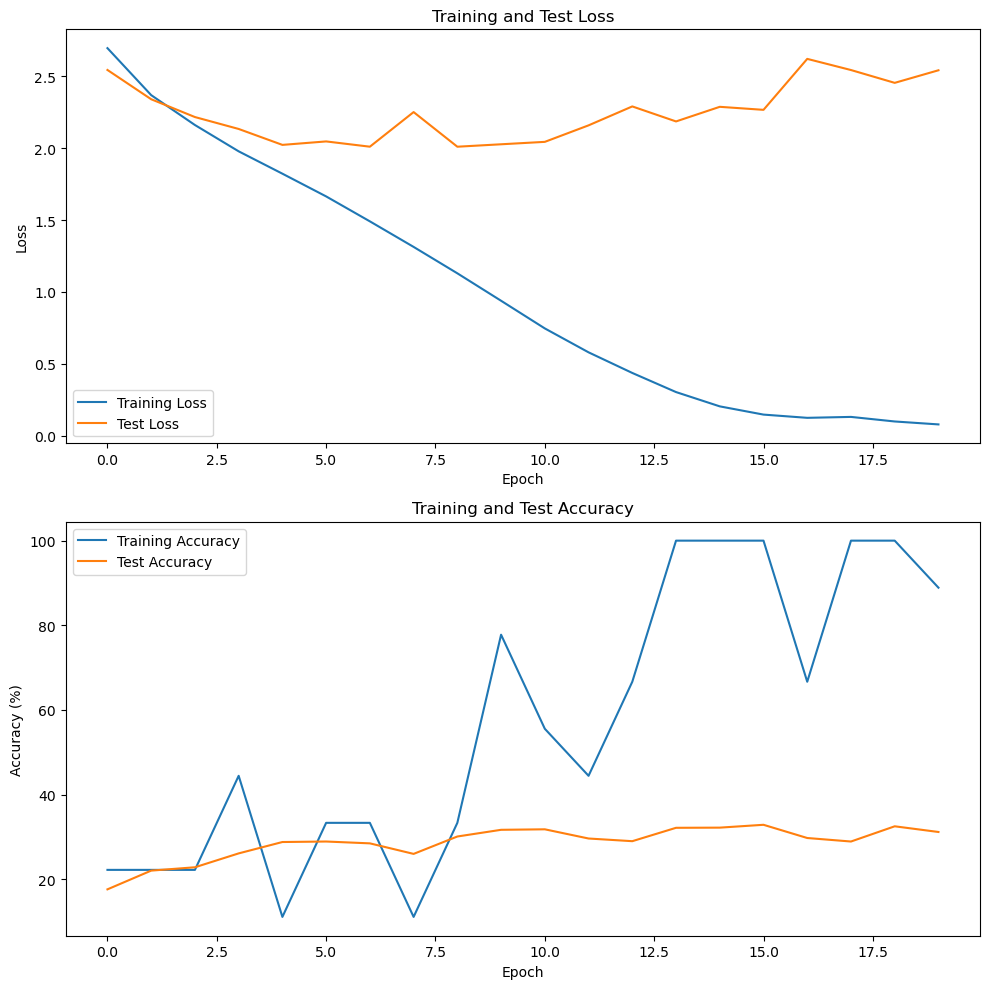

In [41]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-7. resnet18 / SGD(lr=0.001, mo=0.9)

In [42]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [43]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [44]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6991, Accuracy: 11.11%
Test loss: 2.5149, Accuracy: 18.10%
Epoch 2, Training loss: 2.2981, Accuracy: 22.22%
Test loss: 2.2567, Accuracy: 23.55%
Epoch 3, Training loss: 2.0398, Accuracy: 11.11%
Test loss: 2.1511, Accuracy: 25.25%
Epoch 4, Training loss: 1.8358, Accuracy: 22.22%
Test loss: 2.0797, Accuracy: 27.50%
Epoch 5, Training loss: 1.6395, Accuracy: 44.44%
Test loss: 2.0251, Accuracy: 28.45%
Epoch 6, Training loss: 1.4154, Accuracy: 66.67%
Test loss: 2.0184, Accuracy: 29.79%
Epoch 7, Training loss: 1.1941, Accuracy: 44.44%
Test loss: 2.0171, Accuracy: 30.11%
Epoch 8, Training loss: 0.9463, Accuracy: 44.44%
Test loss: 2.0888, Accuracy: 29.00%
Epoch 9, Training loss: 0.7133, Accuracy: 55.56%
Test loss: 2.1187, Accuracy: 30.42%
Epoch 10, Training loss: 0.5012, Accuracy: 88.89%
Test loss: 2.2241, Accuracy: 29.59%
Epoch 11, Training loss: 0.3252, Accuracy: 88.89%
Test loss: 2.3437, Accuracy: 29.95%
Epoch 12, Training loss: 0.2266, Accuracy: 88.89%
Test loss: 2.

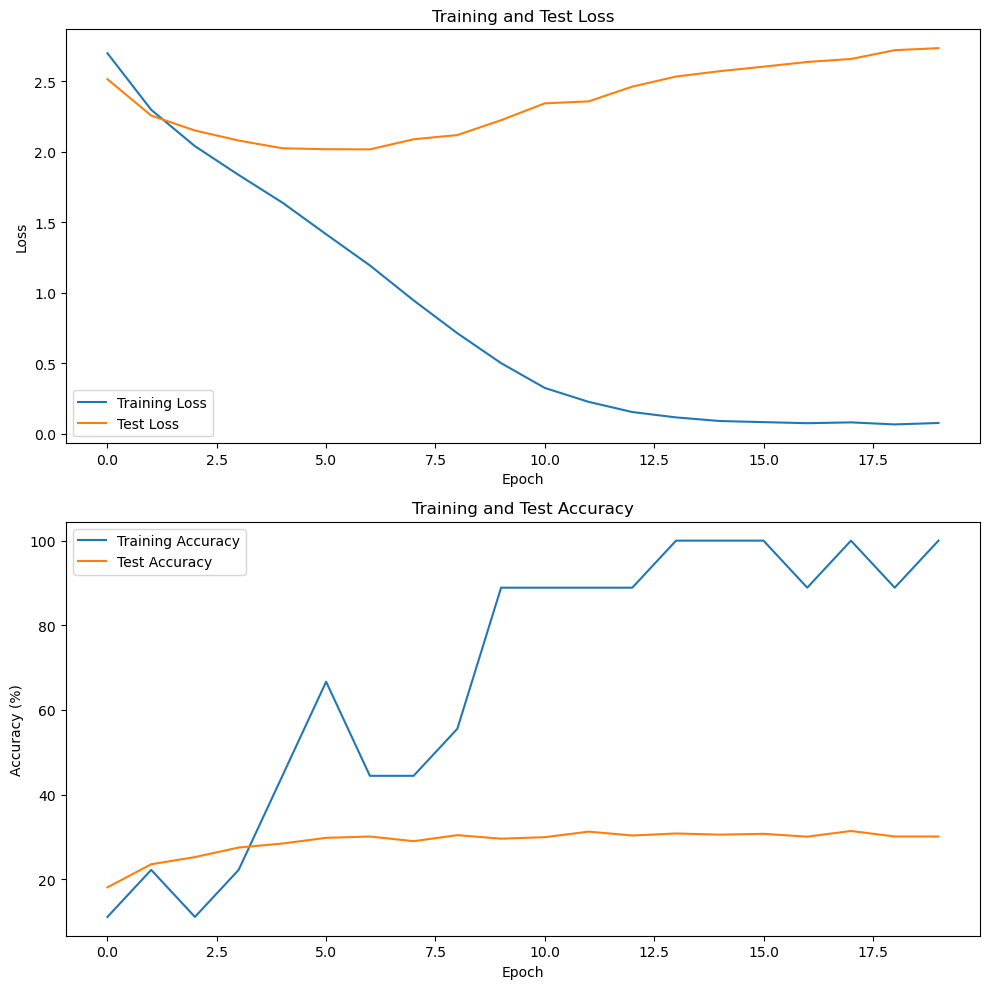

In [45]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-8. resnet18 / SGD(lr=0.001, mo=0.5)

In [46]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [47]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [48]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8269, Accuracy: 33.33%
Test loss: 2.7323, Accuracy: 15.33%
Epoch 2, Training loss: 2.6535, Accuracy: 11.11%
Test loss: 2.6072, Accuracy: 17.78%
Epoch 3, Training loss: 2.5181, Accuracy: 11.11%
Test loss: 2.5132, Accuracy: 19.28%
Epoch 4, Training loss: 2.3975, Accuracy: 33.33%
Test loss: 2.4348, Accuracy: 19.56%
Epoch 5, Training loss: 2.2934, Accuracy: 33.33%
Test loss: 2.3744, Accuracy: 21.77%
Epoch 6, Training loss: 2.1992, Accuracy: 44.44%
Test loss: 2.3080, Accuracy: 22.72%
Epoch 7, Training loss: 2.1100, Accuracy: 44.44%
Test loss: 2.2592, Accuracy: 23.79%
Epoch 8, Training loss: 2.0364, Accuracy: 22.22%
Test loss: 2.2233, Accuracy: 24.50%
Epoch 9, Training loss: 1.9569, Accuracy: 22.22%
Test loss: 2.1866, Accuracy: 25.37%
Epoch 10, Training loss: 1.8864, Accuracy: 22.22%
Test loss: 2.1706, Accuracy: 25.37%
Epoch 11, Training loss: 1.8175, Accuracy: 44.44%
Test loss: 2.1289, Accuracy: 26.67%
Epoch 12, Training loss: 1.7417, Accuracy: 55.56%
Test loss: 2.

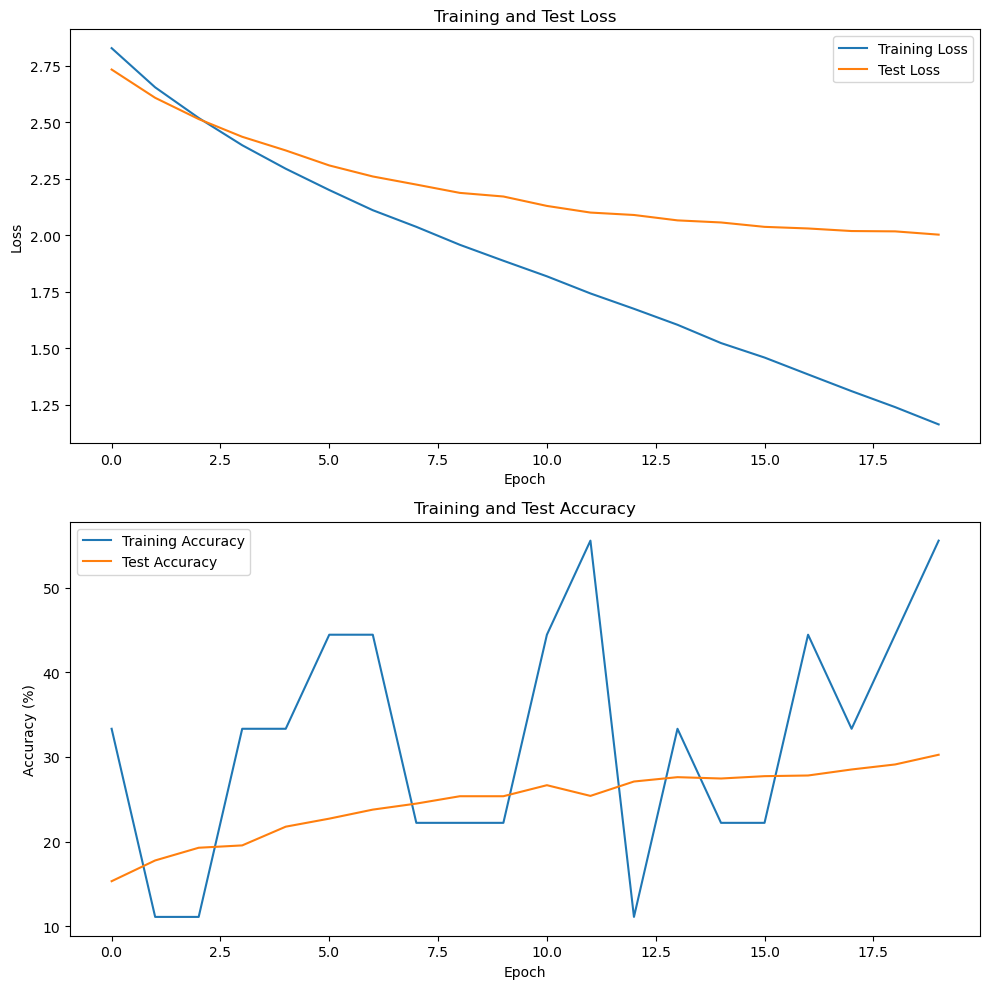

In [49]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-9. resnet18 / SGD(lr=0.001, mo=0.25)

In [50]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.25)

In [51]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [52]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8656, Accuracy: 22.22%
Test loss: 2.7764, Accuracy: 14.34%
Epoch 2, Training loss: 2.7225, Accuracy: 22.22%
Test loss: 2.6883, Accuracy: 15.49%
Epoch 3, Training loss: 2.6242, Accuracy: 22.22%
Test loss: 2.6171, Accuracy: 17.11%
Epoch 4, Training loss: 2.5369, Accuracy: 22.22%
Test loss: 2.5505, Accuracy: 19.16%
Epoch 5, Training loss: 2.4457, Accuracy: 44.44%
Test loss: 2.4865, Accuracy: 19.44%
Epoch 6, Training loss: 2.3670, Accuracy: 33.33%
Test loss: 2.4242, Accuracy: 20.31%
Epoch 7, Training loss: 2.2865, Accuracy: 11.11%
Test loss: 2.3827, Accuracy: 22.20%
Epoch 8, Training loss: 2.2180, Accuracy: 33.33%
Test loss: 2.3315, Accuracy: 22.84%
Epoch 9, Training loss: 2.1568, Accuracy: 11.11%
Test loss: 2.2958, Accuracy: 23.79%
Epoch 10, Training loss: 2.0917, Accuracy: 33.33%
Test loss: 2.2637, Accuracy: 23.31%
Epoch 11, Training loss: 2.0397, Accuracy: 33.33%
Test loss: 2.2441, Accuracy: 23.75%
Epoch 12, Training loss: 1.9858, Accuracy: 33.33%
Test loss: 2.

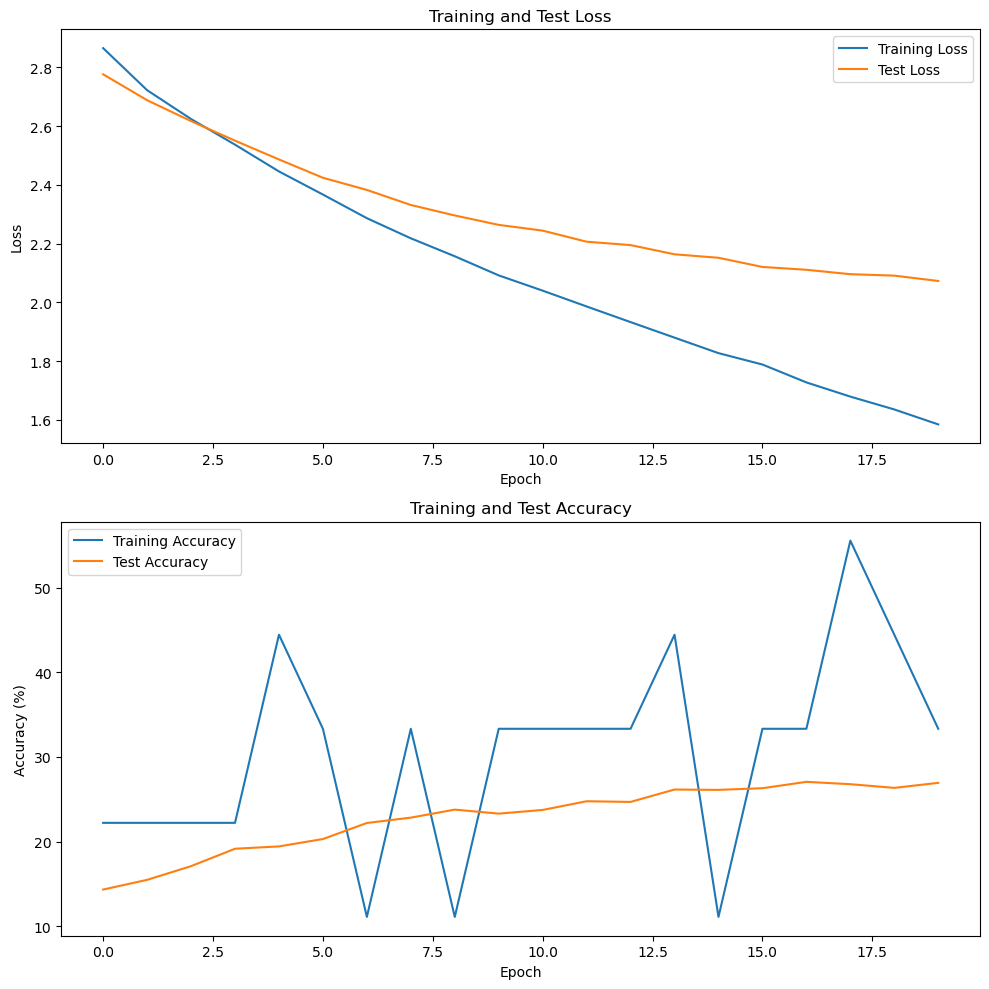

In [53]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-1. resnet18 / RMSprop(lr=0.010, mo=0.9)

In [56]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.9)

In [57]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [58]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 4.1152, Accuracy: 22.22%
Test loss: 3.6646, Accuracy: 7.90%
Epoch 2, Training loss: 2.8882, Accuracy: 0.00%
Test loss: 6.0609, Accuracy: 11.18%
Epoch 3, Training loss: 2.8614, Accuracy: 0.00%
Test loss: 2.8247, Accuracy: 11.93%
Epoch 4, Training loss: 2.7687, Accuracy: 11.11%
Test loss: 2.9166, Accuracy: 13.51%
Epoch 5, Training loss: 2.4851, Accuracy: 55.56%
Test loss: 2.4362, Accuracy: 17.11%
Epoch 6, Training loss: 2.3886, Accuracy: 11.11%
Test loss: 2.8705, Accuracy: 15.92%
Epoch 7, Training loss: 2.3251, Accuracy: 22.22%
Test loss: 2.3253, Accuracy: 17.34%
Epoch 8, Training loss: 2.1927, Accuracy: 22.22%
Test loss: 2.2095, Accuracy: 17.07%
Epoch 9, Training loss: 2.0706, Accuracy: 22.22%
Test loss: 2.0327, Accuracy: 26.35%
Epoch 10, Training loss: 1.9630, Accuracy: 22.22%
Test loss: 1.9982, Accuracy: 27.42%
Epoch 11, Training loss: 1.9010, Accuracy: 55.56%
Test loss: 1.9224, Accuracy: 28.17%
Epoch 12, Training loss: 1.8439, Accuracy: 22.22%
Test loss: 1.872

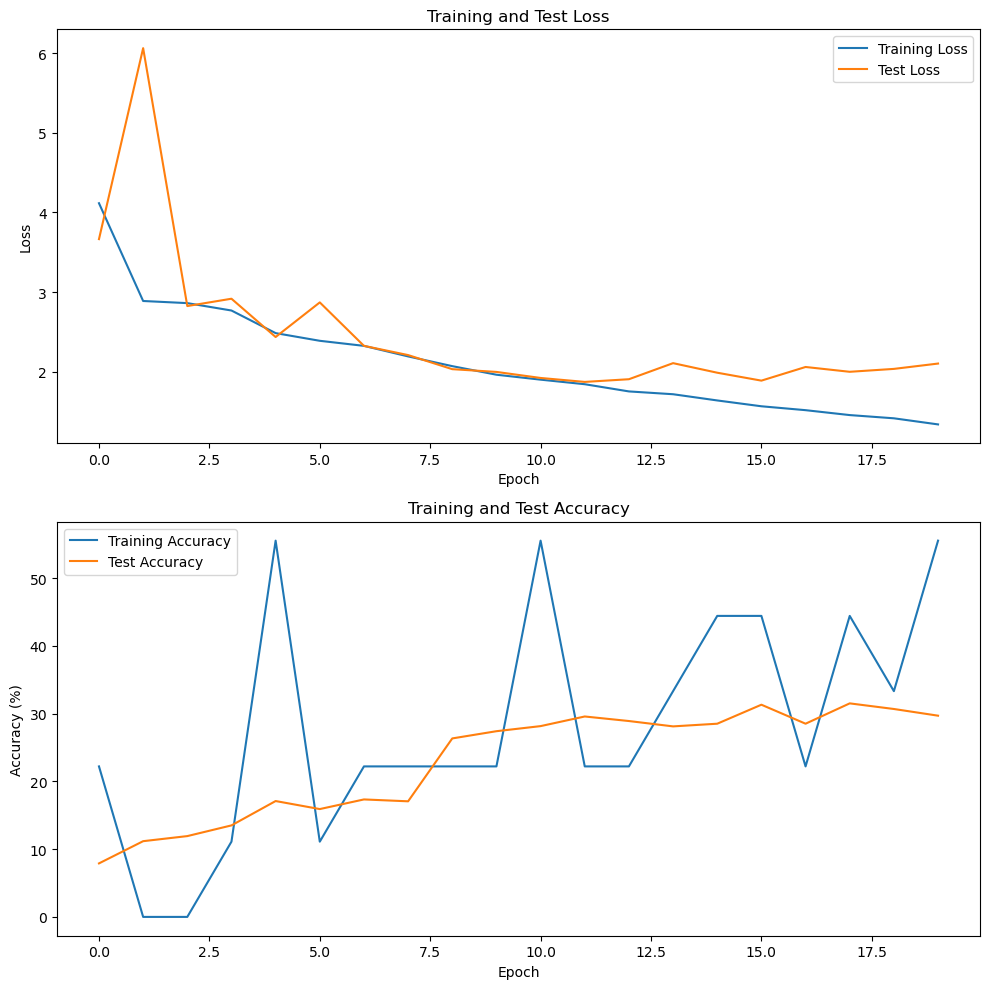

In [59]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-2. resnet18 / RMSprop(lr=0.010, mo=0.5)

In [60]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.5)

In [61]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [62]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.4686, Accuracy: 44.44%
Test loss: 2.8516, Accuracy: 10.27%
Epoch 2, Training loss: 2.7051, Accuracy: 0.00%
Test loss: 2.8055, Accuracy: 14.26%
Epoch 3, Training loss: 2.2959, Accuracy: 0.00%
Test loss: 2.5717, Accuracy: 16.28%
Epoch 4, Training loss: 2.0738, Accuracy: 11.11%
Test loss: 2.3900, Accuracy: 20.19%
Epoch 5, Training loss: 1.9364, Accuracy: 11.11%
Test loss: 2.1411, Accuracy: 26.00%
Epoch 6, Training loss: 1.8414, Accuracy: 22.22%
Test loss: 3.0243, Accuracy: 17.46%
Epoch 7, Training loss: 1.7269, Accuracy: 22.22%
Test loss: 2.2497, Accuracy: 25.01%
Epoch 8, Training loss: 1.6290, Accuracy: 22.22%
Test loss: 1.8642, Accuracy: 31.49%
Epoch 9, Training loss: 1.5394, Accuracy: 44.44%
Test loss: 1.9172, Accuracy: 28.61%
Epoch 10, Training loss: 1.4498, Accuracy: 44.44%
Test loss: 1.8955, Accuracy: 32.04%
Epoch 11, Training loss: 1.3369, Accuracy: 55.56%
Test loss: 1.9247, Accuracy: 31.61%
Epoch 12, Training loss: 1.2500, Accuracy: 22.22%
Test loss: 2.02

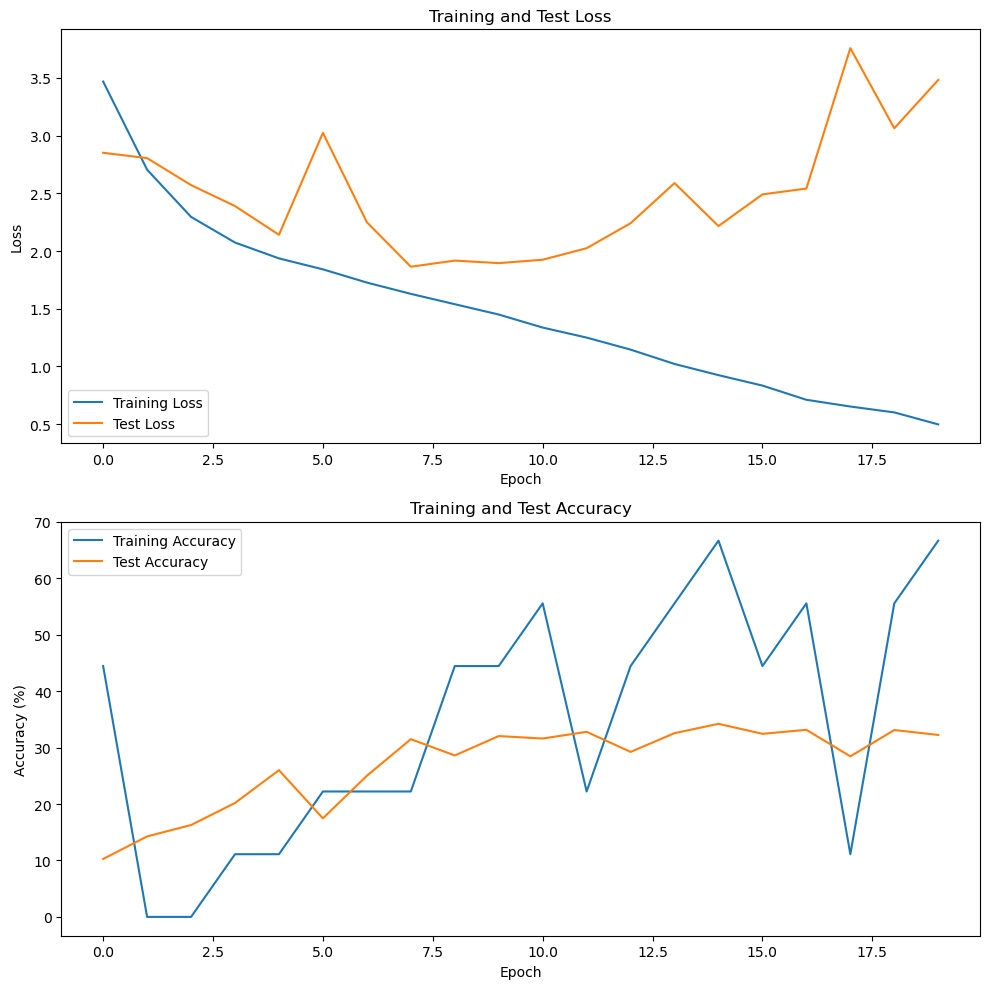

In [63]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-3. resnet18 / RMSprop(lr=0.010, mo=0.25)

In [64]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.25)

In [65]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [66]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.2506, Accuracy: 22.22%
Test loss: 2.8130, Accuracy: 13.16%
Epoch 2, Training loss: 2.5236, Accuracy: 11.11%
Test loss: 2.4590, Accuracy: 17.94%
Epoch 3, Training loss: 2.1858, Accuracy: 11.11%
Test loss: 5.0067, Accuracy: 9.01%
Epoch 4, Training loss: 2.0393, Accuracy: 33.33%
Test loss: 2.8448, Accuracy: 16.00%
Epoch 5, Training loss: 1.8876, Accuracy: 33.33%
Test loss: 2.1343, Accuracy: 24.10%
Epoch 6, Training loss: 1.7765, Accuracy: 33.33%
Test loss: 2.1332, Accuracy: 24.50%
Epoch 7, Training loss: 1.6678, Accuracy: 33.33%
Test loss: 2.4230, Accuracy: 22.60%
Epoch 8, Training loss: 1.5699, Accuracy: 33.33%
Test loss: 2.0129, Accuracy: 31.09%
Epoch 9, Training loss: 1.4806, Accuracy: 22.22%
Test loss: 2.2109, Accuracy: 28.01%
Epoch 10, Training loss: 1.3740, Accuracy: 11.11%
Test loss: 2.4384, Accuracy: 25.01%
Epoch 11, Training loss: 1.2619, Accuracy: 33.33%
Test loss: 2.2202, Accuracy: 32.48%
Epoch 12, Training loss: 1.1322, Accuracy: 22.22%
Test loss: 2.6

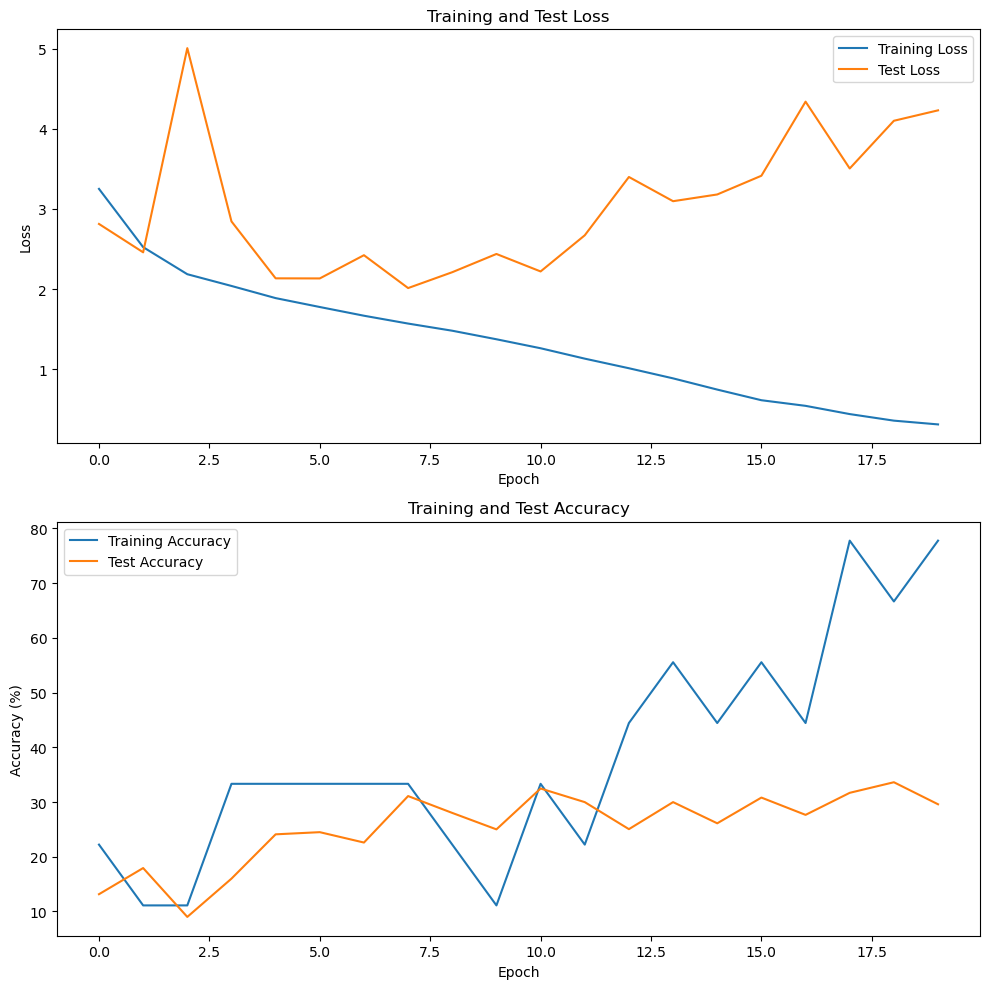

In [67]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-4. resnet18 / RMSprop(lr=0.005, mo=0.9)

In [68]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9)

In [69]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [70]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.4383, Accuracy: 11.11%
Test loss: 2.8631, Accuracy: 8.97%
Epoch 2, Training loss: 2.8379, Accuracy: 11.11%
Test loss: 2.8414, Accuracy: 8.97%
Epoch 3, Training loss: 2.6980, Accuracy: 33.33%
Test loss: 3.2268, Accuracy: 12.60%
Epoch 4, Training loss: 2.2862, Accuracy: 22.22%
Test loss: 2.2974, Accuracy: 16.08%
Epoch 5, Training loss: 2.1165, Accuracy: 11.11%
Test loss: 2.1362, Accuracy: 24.22%
Epoch 6, Training loss: 1.9857, Accuracy: 33.33%
Test loss: 2.0715, Accuracy: 25.80%
Epoch 7, Training loss: 1.8938, Accuracy: 33.33%
Test loss: 1.9260, Accuracy: 28.88%
Epoch 8, Training loss: 1.8143, Accuracy: 66.67%
Test loss: 2.0339, Accuracy: 27.38%
Epoch 9, Training loss: 1.7502, Accuracy: 55.56%
Test loss: 1.9040, Accuracy: 29.12%
Epoch 10, Training loss: 1.6792, Accuracy: 33.33%
Test loss: 1.8497, Accuracy: 29.47%
Epoch 11, Training loss: 1.6068, Accuracy: 33.33%
Test loss: 1.9175, Accuracy: 31.73%
Epoch 12, Training loss: 1.5287, Accuracy: 44.44%
Test loss: 1.85

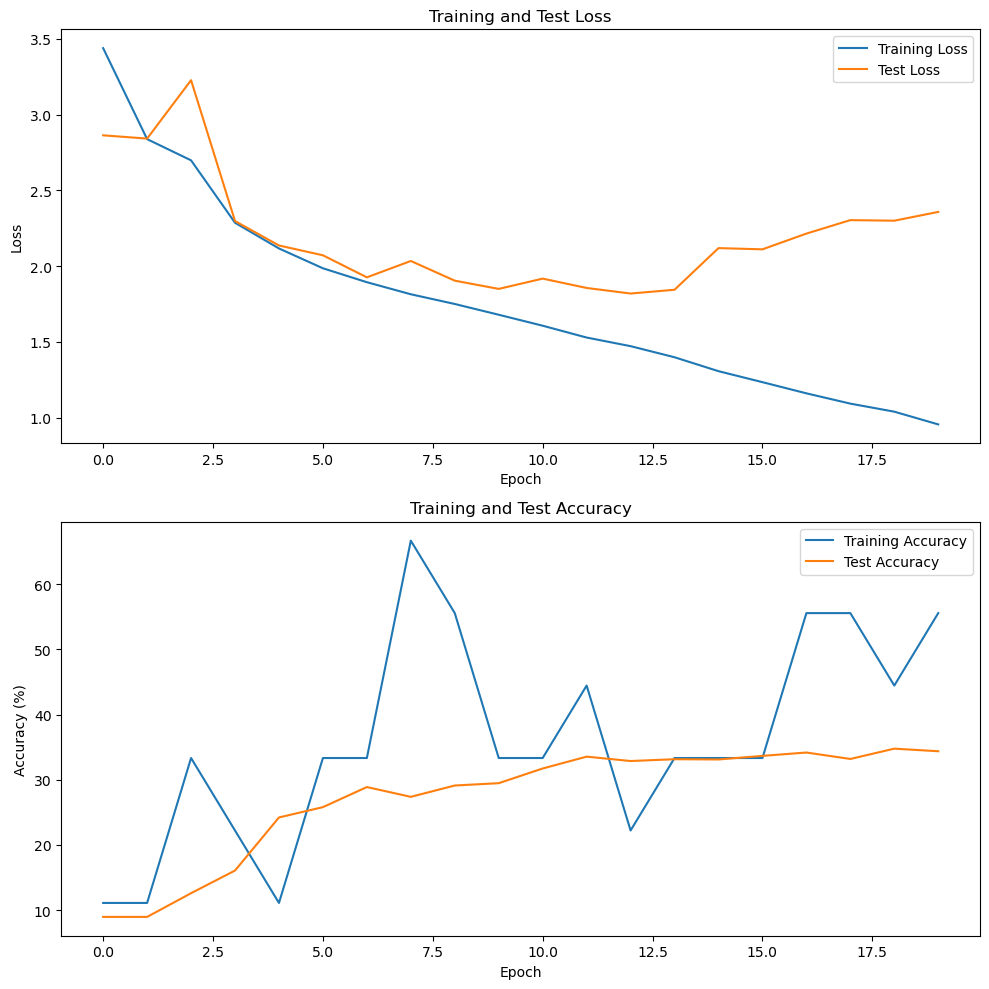

In [71]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-5. resnet18 / RMSprop(lr=0.005, mo=0.5)

In [72]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.5)

In [73]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [74]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1441, Accuracy: 11.11%
Test loss: 2.6435, Accuracy: 15.33%
Epoch 2, Training loss: 2.4020, Accuracy: 11.11%
Test loss: 3.3737, Accuracy: 8.73%
Epoch 3, Training loss: 2.1588, Accuracy: 44.44%
Test loss: 2.5229, Accuracy: 19.04%
Epoch 4, Training loss: 1.9682, Accuracy: 33.33%
Test loss: 2.9034, Accuracy: 21.06%
Epoch 5, Training loss: 1.8645, Accuracy: 22.22%
Test loss: 2.7306, Accuracy: 15.96%
Epoch 6, Training loss: 1.7569, Accuracy: 33.33%
Test loss: 2.1544, Accuracy: 26.63%
Epoch 7, Training loss: 1.6298, Accuracy: 22.22%
Test loss: 1.9071, Accuracy: 30.58%
Epoch 8, Training loss: 1.5034, Accuracy: 44.44%
Test loss: 1.8736, Accuracy: 33.11%
Epoch 9, Training loss: 1.4148, Accuracy: 33.33%
Test loss: 1.8917, Accuracy: 32.08%
Epoch 10, Training loss: 1.2860, Accuracy: 77.78%
Test loss: 2.1989, Accuracy: 32.04%
Epoch 11, Training loss: 1.1333, Accuracy: 55.56%
Test loss: 2.1552, Accuracy: 32.99%
Epoch 12, Training loss: 0.9871, Accuracy: 55.56%
Test loss: 2.1

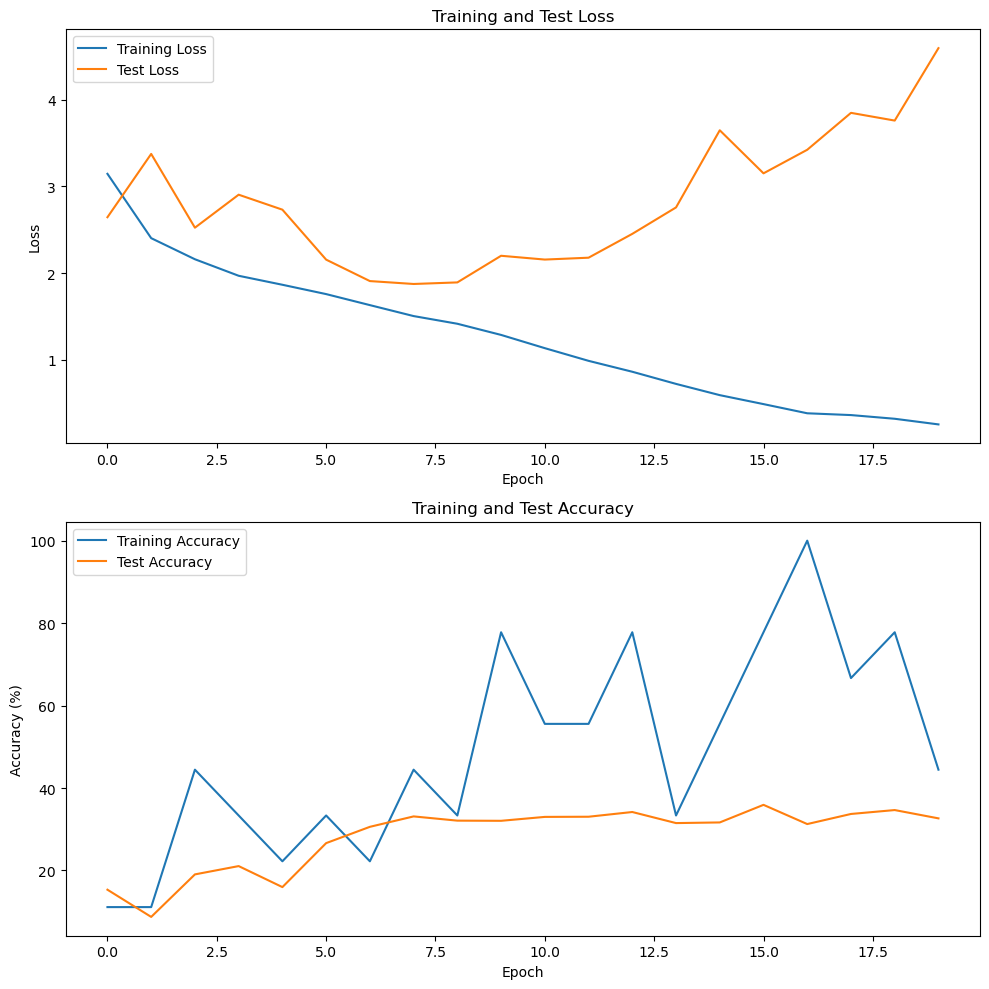

In [75]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-6. resnet18 / RMSprop(lr=0.005, mo=0.25)

In [76]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.25)

In [77]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [78]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.2453, Accuracy: 11.11%
Test loss: 3.5067, Accuracy: 5.37%
Epoch 2, Training loss: 2.5626, Accuracy: 0.00%
Test loss: 2.7113, Accuracy: 15.57%
Epoch 3, Training loss: 2.1989, Accuracy: 11.11%
Test loss: 2.6704, Accuracy: 15.80%
Epoch 4, Training loss: 2.0179, Accuracy: 33.33%
Test loss: 2.3976, Accuracy: 20.58%
Epoch 5, Training loss: 1.8856, Accuracy: 11.11%
Test loss: 4.2595, Accuracy: 20.19%
Epoch 6, Training loss: 1.7658, Accuracy: 33.33%
Test loss: 3.0955, Accuracy: 17.19%
Epoch 7, Training loss: 1.6774, Accuracy: 11.11%
Test loss: 2.4078, Accuracy: 22.60%
Epoch 8, Training loss: 1.5333, Accuracy: 33.33%
Test loss: 1.9931, Accuracy: 29.91%
Epoch 9, Training loss: 1.4016, Accuracy: 55.56%
Test loss: 2.2116, Accuracy: 27.93%
Epoch 10, Training loss: 1.2503, Accuracy: 33.33%
Test loss: 2.1778, Accuracy: 28.33%
Epoch 11, Training loss: 1.0608, Accuracy: 44.44%
Test loss: 2.5903, Accuracy: 30.15%
Epoch 12, Training loss: 0.8680, Accuracy: 44.44%
Test loss: 2.69

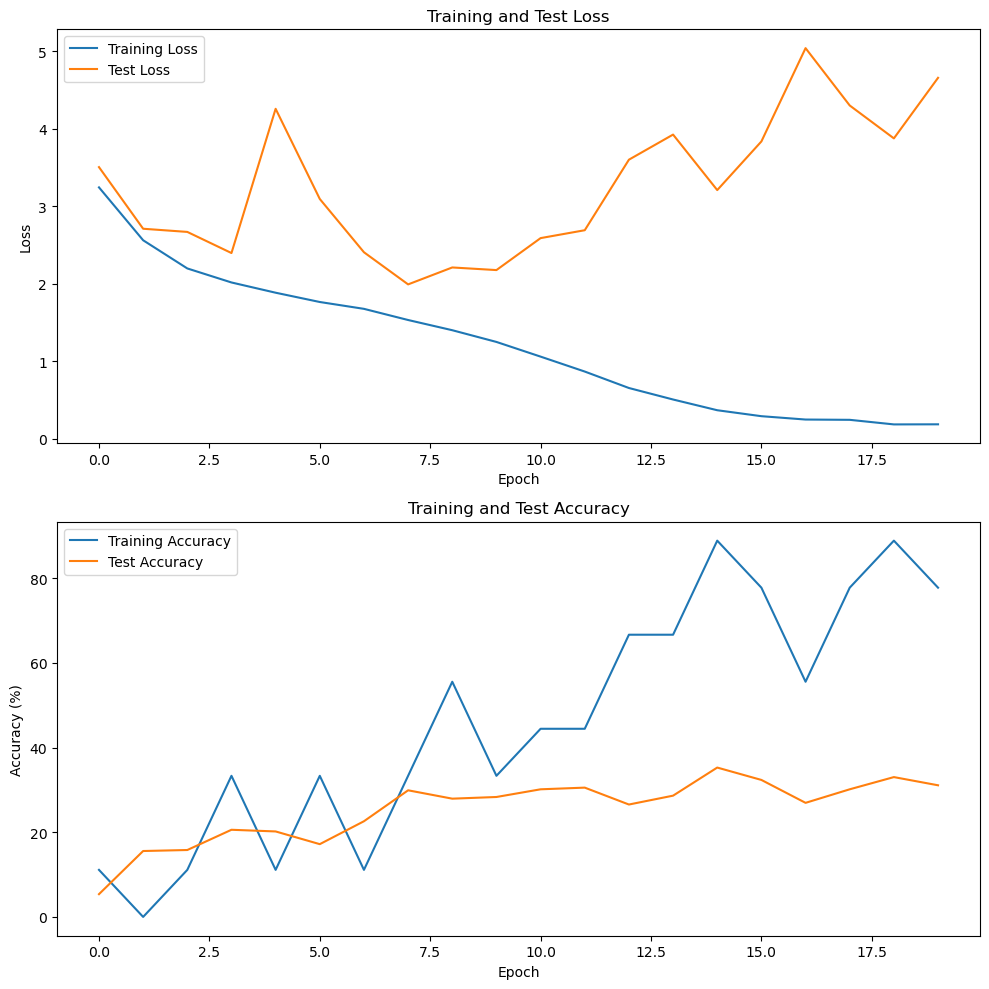

In [79]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-7. resnet18 / RMSprop(lr=0.001, mo=0.9)

In [80]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [81]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [82]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.0665, Accuracy: 33.33%
Test loss: 2.5830, Accuracy: 17.34%
Epoch 2, Training loss: 2.3846, Accuracy: 22.22%
Test loss: 2.4971, Accuracy: 20.70%
Epoch 3, Training loss: 2.1837, Accuracy: 11.11%
Test loss: 2.3118, Accuracy: 22.96%
Epoch 4, Training loss: 2.0290, Accuracy: 11.11%
Test loss: 2.1534, Accuracy: 25.01%
Epoch 5, Training loss: 1.9334, Accuracy: 33.33%
Test loss: 1.9266, Accuracy: 30.30%
Epoch 6, Training loss: 1.8092, Accuracy: 22.22%
Test loss: 2.0265, Accuracy: 30.94%
Epoch 7, Training loss: 1.7088, Accuracy: 33.33%
Test loss: 1.8581, Accuracy: 31.29%
Epoch 8, Training loss: 1.6028, Accuracy: 33.33%
Test loss: 1.8419, Accuracy: 33.50%
Epoch 9, Training loss: 1.4823, Accuracy: 55.56%
Test loss: 1.9207, Accuracy: 31.85%
Epoch 10, Training loss: 1.3662, Accuracy: 44.44%
Test loss: 1.8845, Accuracy: 32.99%
Epoch 11, Training loss: 1.2624, Accuracy: 33.33%
Test loss: 2.0369, Accuracy: 33.90%
Epoch 12, Training loss: 1.0818, Accuracy: 66.67%
Test loss: 2.

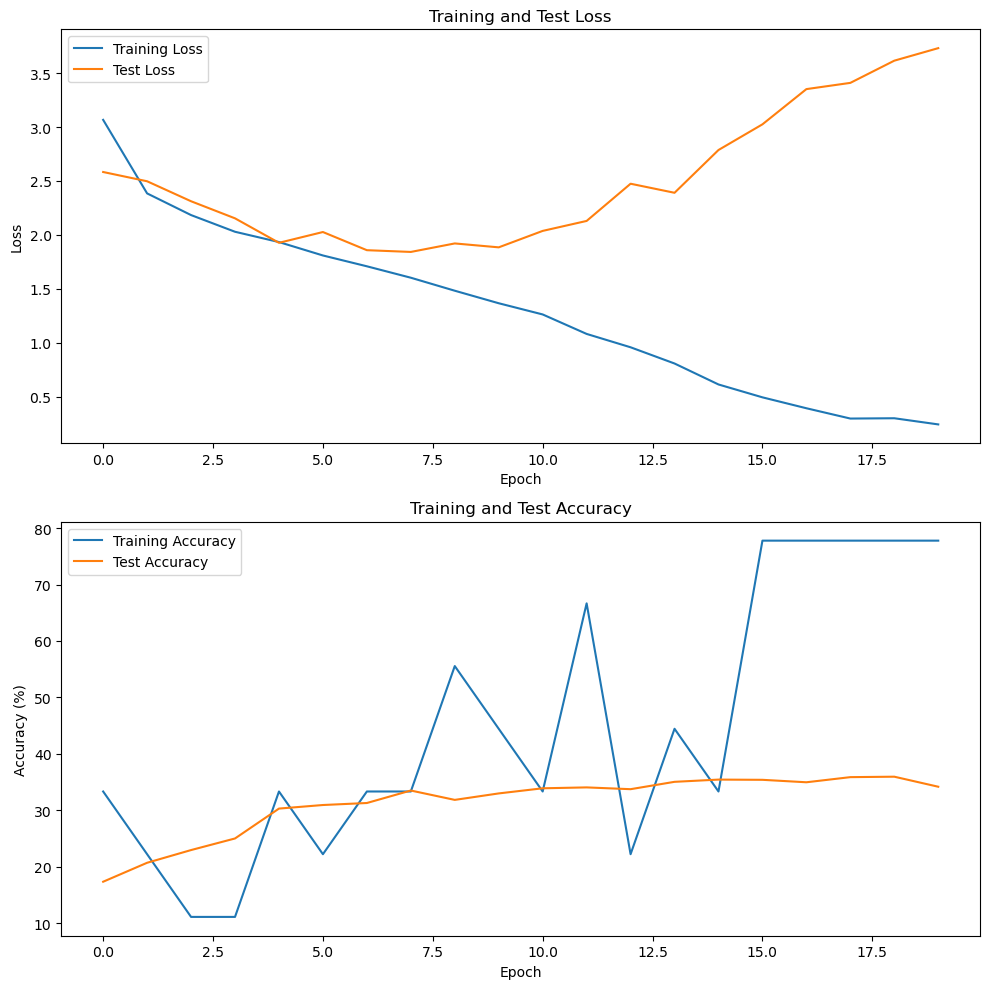

In [83]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-8. resnet18 / RMSprop(lr=0.001, mo=0.5)

In [84]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)

In [85]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [86]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6171, Accuracy: 11.11%
Test loss: 3.8295, Accuracy: 16.67%
Epoch 2, Training loss: 2.1055, Accuracy: 0.00%
Test loss: 2.7380, Accuracy: 15.76%
Epoch 3, Training loss: 1.9379, Accuracy: 11.11%
Test loss: 2.7634, Accuracy: 24.10%
Epoch 4, Training loss: 1.7932, Accuracy: 33.33%
Test loss: 2.8164, Accuracy: 20.55%
Epoch 5, Training loss: 1.6727, Accuracy: 22.22%
Test loss: 2.9691, Accuracy: 24.69%
Epoch 6, Training loss: 1.5602, Accuracy: 11.11%
Test loss: 2.2141, Accuracy: 26.91%
Epoch 7, Training loss: 1.4317, Accuracy: 44.44%
Test loss: 2.0855, Accuracy: 30.15%
Epoch 8, Training loss: 1.2842, Accuracy: 33.33%
Test loss: 1.9417, Accuracy: 34.65%
Epoch 9, Training loss: 1.1311, Accuracy: 44.44%
Test loss: 2.8191, Accuracy: 26.99%
Epoch 10, Training loss: 0.9702, Accuracy: 55.56%
Test loss: 2.8273, Accuracy: 31.33%
Epoch 11, Training loss: 0.8047, Accuracy: 33.33%
Test loss: 2.3718, Accuracy: 32.91%
Epoch 12, Training loss: 0.6256, Accuracy: 55.56%
Test loss: 2.7

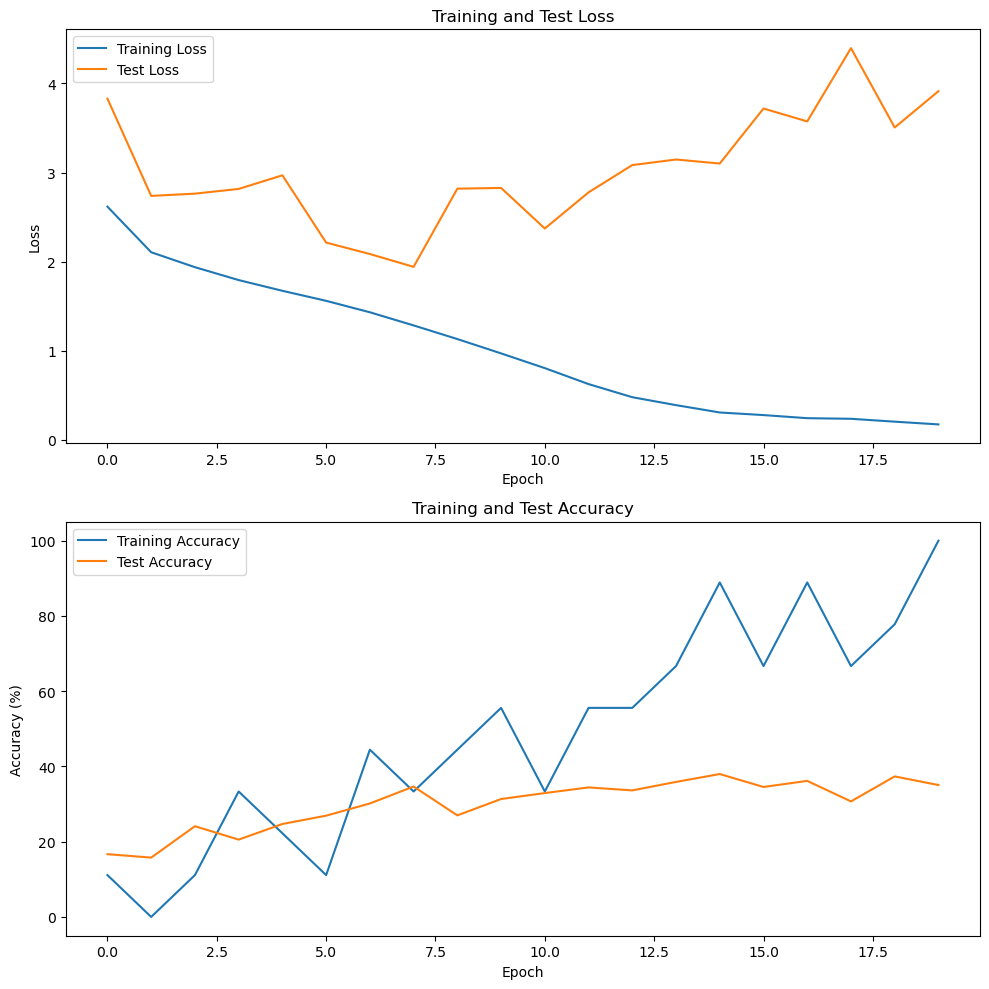

In [87]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-9. resnet18 / RMSprop(lr=0.001, mo=0.25)

In [88]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.25)

In [89]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [90]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6388, Accuracy: 22.22%
Test loss: 4.1960, Accuracy: 14.62%
Epoch 2, Training loss: 2.1556, Accuracy: 22.22%
Test loss: 2.8518, Accuracy: 16.63%
Epoch 3, Training loss: 1.9668, Accuracy: 44.44%
Test loss: 2.5353, Accuracy: 25.09%
Epoch 4, Training loss: 1.8177, Accuracy: 0.00%
Test loss: 2.5919, Accuracy: 23.63%
Epoch 5, Training loss: 1.6941, Accuracy: 44.44%
Test loss: 2.4520, Accuracy: 20.51%
Epoch 6, Training loss: 1.5542, Accuracy: 33.33%
Test loss: 2.1579, Accuracy: 28.68%
Epoch 7, Training loss: 1.4287, Accuracy: 33.33%
Test loss: 2.4530, Accuracy: 26.16%
Epoch 8, Training loss: 1.2815, Accuracy: 33.33%
Test loss: 3.7977, Accuracy: 18.45%
Epoch 9, Training loss: 1.1559, Accuracy: 66.67%
Test loss: 2.7993, Accuracy: 25.40%
Epoch 10, Training loss: 0.9861, Accuracy: 44.44%
Test loss: 2.8647, Accuracy: 28.37%
Epoch 11, Training loss: 0.8304, Accuracy: 33.33%
Test loss: 2.7919, Accuracy: 31.53%
Epoch 12, Training loss: 0.6746, Accuracy: 66.67%
Test loss: 2.8

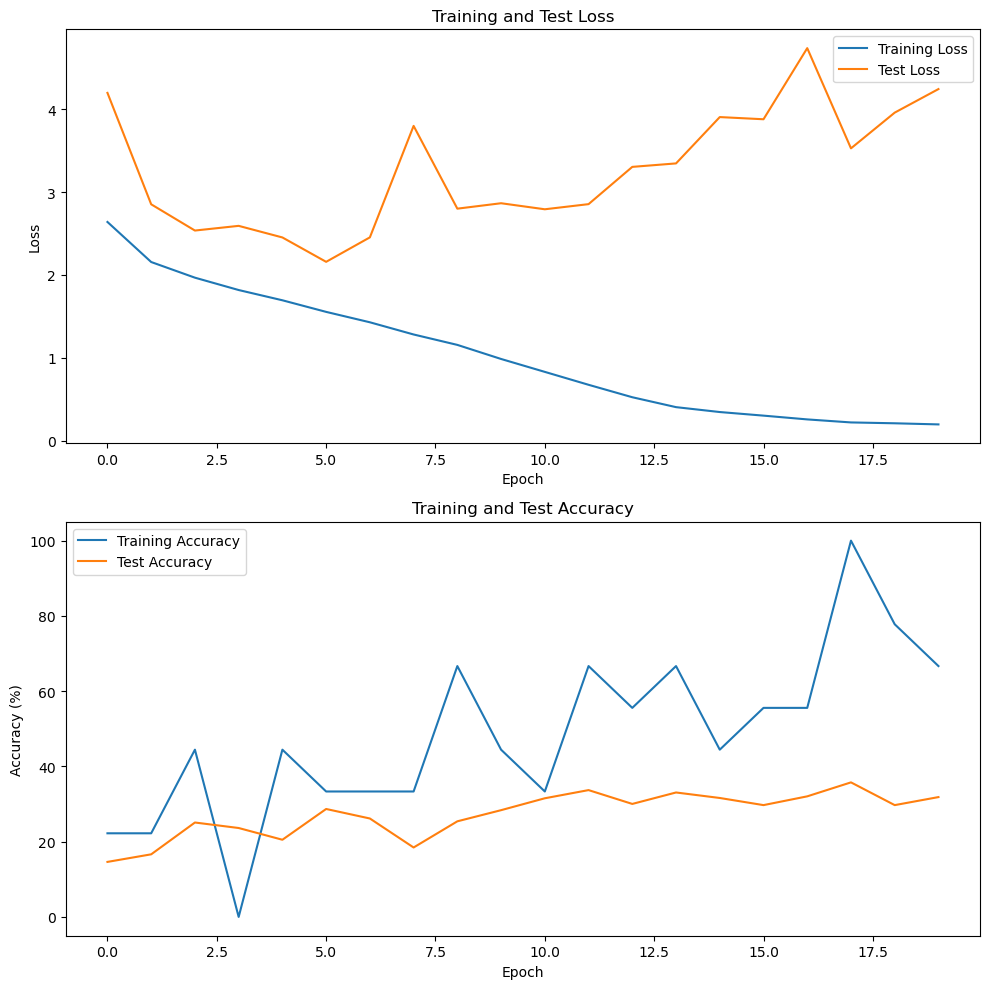

In [91]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)